<h2>Handling Class Imbalance In Credit Card Fraud Detection</h2>
<h3>Name: Tarandeep </h3>


In [66]:
from collections import Counter
import pickle
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report, auc, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
import matplotlib.gridspec as gridspec
%matplotlib notebook

In [41]:
data = pd.read_csv("data/creditcard.csv")

## 1. VISUALIZE THE DATA

In [42]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


<IPython.core.display.Javascript object>


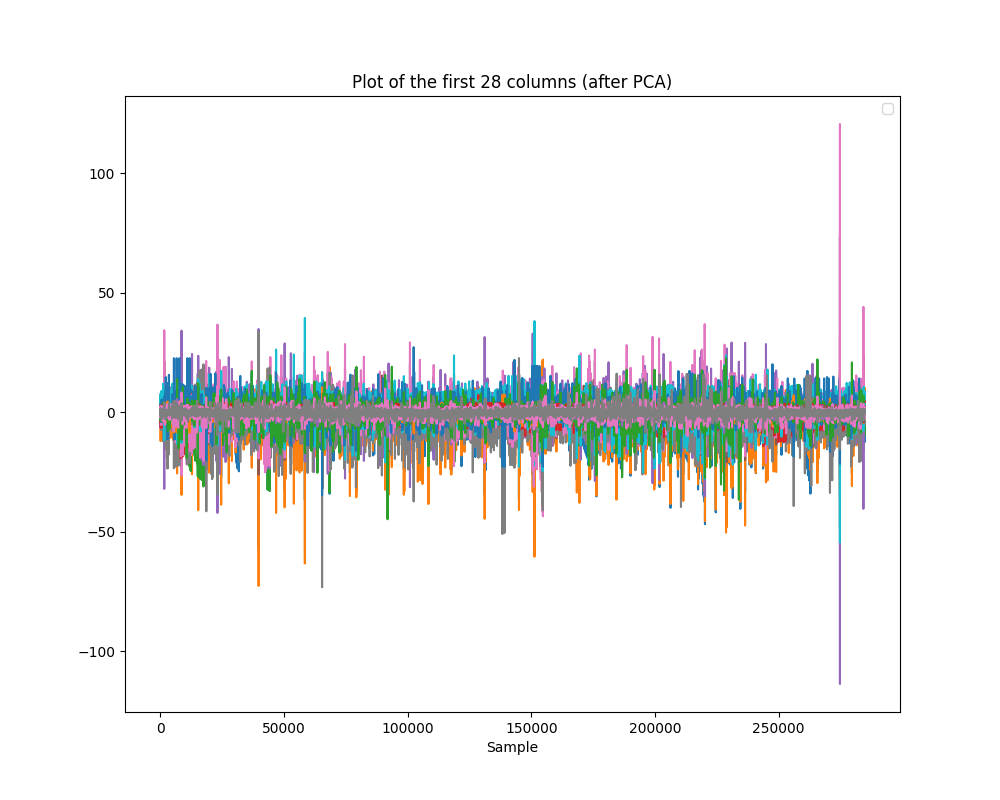

No handles with labels found to put in legend.


Text(0.5, 0, 'Sample')

In [43]:
# plot the features
plt.figure(figsize=(10,8))
for a in range(1, 29):
    plt.plot(data['V'+str(a)])
plt.legend(loc='best', fontsize=10, ncol=8)
plt.title("Plot of the first 28 columns (after PCA)")
plt.xlabel("Sample")

In [44]:
data.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

<IPython.core.display.Javascript object>


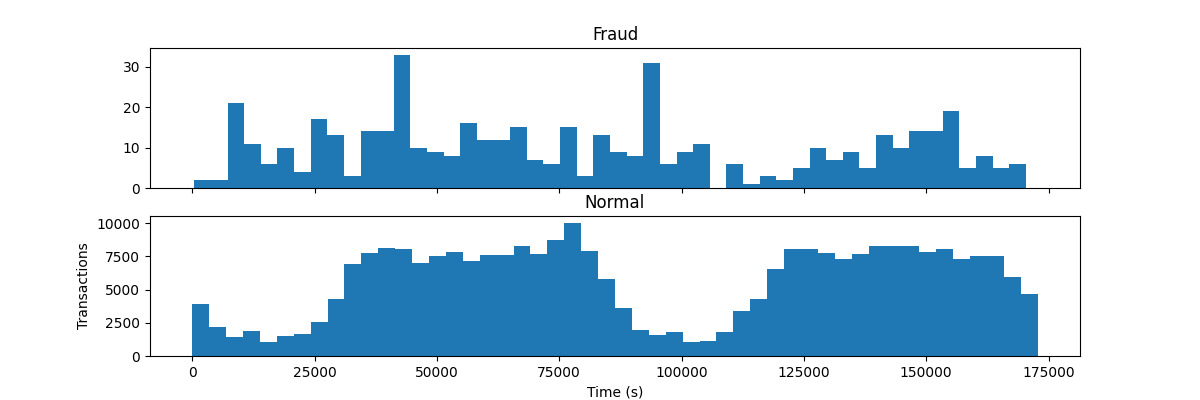

In [45]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))
ax1.hist(data.Time[data.Class == 1], bins = 50)
ax1.set_title('Fraud')
ax2.hist(data.Time[data.Class == 0], bins = 50)
ax2.set_title('Normal')
plt.xlabel('Time (s)')
plt.ylabel('Transactions')
plt.show()

<IPython.core.display.Javascript object>


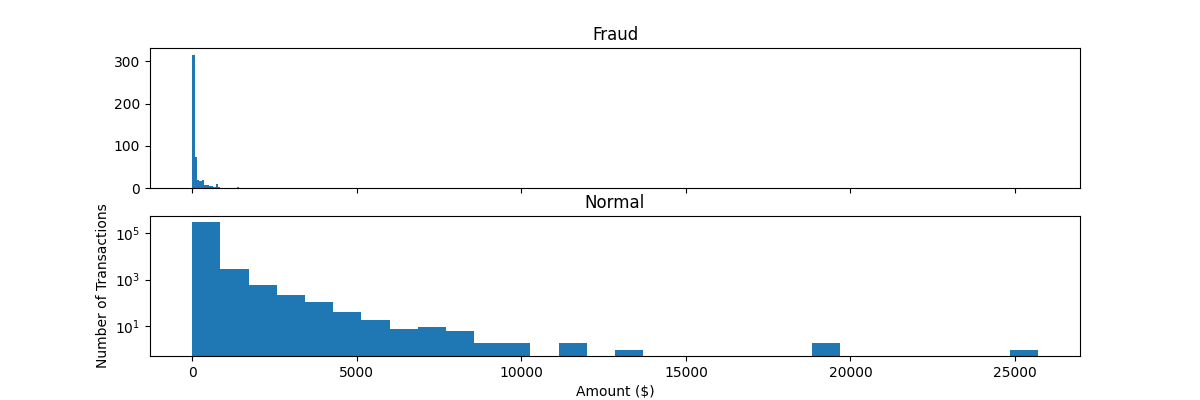

In [49]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))
ax1.hist(data.Amount[data.Class == 1], bins = 30)
ax1.set_title('Fraud')
ax2.hist(data.Amount[data.Class == 0], bins = 30)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.yscale('log')
plt.show()

In [52]:
clean_data = data.drop(['V28','V27','V23','V8'], axis =1)
# Later - can re run everything after running the following line
#data = clean_data

## 2. PREPARE DATASET

In [44]:
#Creating dataframes of only Fraud and Normal transactions. Also Shuffling them.
fraud = shuffle(data[data.Class == 1])
normal = shuffle(data[data.Class == 0])
# Producing a training set of 80% of fraudulent and 80% normal transactions
X_train = fraud.sample(frac=0.8)
X_train = pd.concat([X_train, normal.sample(frac = 0.8)], axis = 0)
# Splitting remainder into testing and validation
remainder = data.loc[~data.index.isin(X_train.index)]
X_test = remainder.sample(frac=0.7)
X_validation = remainder.loc[~remainder.index.isin(X_test.index)]

In [45]:
# Resampling the Training Data using ADASYN
# The test data remains imbalanced
with open('pickle/train_data_resampled.pkl', 'rb') as f:
    X_train_resampled = pickle.load(f)
with open('pickle/train_data_labels_resampled.pkl', 'rb') as f:
    X_train_labels_resampled = pickle.load(f)
    
print(Counter(X_train_labels_resampled))
    
X_train_resampled = pd.DataFrame(X_train_resampled)
X_train_labels_resampled = pd.DataFrame(X_train_labels_resampled)
X_train_resampled = pd.concat([X_train_resampled, X_train_labels_resampled], axis=1)
X_train_resampled.columns = X_train.columns
X_train_resampled.head()

Counter({0: 227452, 1: 227324})


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,41233,-10.645800,5.918307,-11.671043,8.807369,-7.975501,-3.586806,-13.616797,6.428169,-7.368451,...,2.571970,0.206809,-1.667801,0.558419,-0.027898,0.354254,0.273329,-0.152908,0.00,1
1,53451,0.385108,1.217620,-1.953872,2.087076,-1.144225,-0.576888,-2.582865,0.643230,-1.191233,...,0.594623,0.372144,-0.310456,-0.624065,0.840216,-0.159452,0.599482,0.288916,8.00,1
2,26556,-19.179826,11.817922,-21.919174,6.086236,-14.708845,-4.308888,-15.357952,12.857165,-3.999861,...,1.746802,-1.353149,-0.762965,0.117028,1.297994,-0.224825,1.621052,0.484614,99.99,1
3,102489,-2.296987,4.064043,-5.957706,4.680008,-2.080938,-1.463272,-4.490847,1.029246,-1.593249,...,1.089084,0.975398,-0.625530,-0.535181,0.247435,0.160400,0.969582,0.335041,104.00,1
4,154493,-7.381547,-7.449015,-4.696287,3.728439,6.198304,-6.406267,-5.831452,1.457175,-0.646203,...,1.176575,-0.978692,-0.278330,-0.635874,0.123539,0.404729,0.704915,-1.229992,35.00,1


In [46]:
# Shuffling the datasets once more to ensure random feeding into the classification algorithms
X_train = shuffle(X_train)
X_test = shuffle(X_test)
X_validation = shuffle(X_validation)
X_train_ = shuffle(X_train_resampled)
X_test_ = shuffle(X_test)
X_validation_ = shuffle(X_validation)
data_resampled = pd.concat([X_train_, X_test_, X_validation_])

In [47]:
# Normalize the data to an average of 0 and std of 1
for feature in X_train.columns.values[:-1]:
    mean, std = data[feature].mean(), data[feature].std()
    X_train.loc[:, feature] = (X_train[feature] - mean) / std
    X_test.loc[:, feature] = (X_test[feature] - mean) / std
    X_validation.loc[:, feature] = (X_validation[feature] - mean) / std
for feature in X_train_.columns.values[:-1]:
    mean, std = data_resampled[feature].mean(), data_resampled[feature].std()
    X_train_.loc[:, feature] = (X_train_[feature] - mean) / std
    X_test_.loc[:, feature] = (X_test_[feature] - mean) / std
    X_validation_.loc[:, feature] = (X_validation_[feature] - mean) / std

In [48]:
# Creating labels
y_train = X_train.Class
y_test = X_test.Class
y_validation = X_validation.Class
y_train_ = X_train_.Class
y_test_ = X_test_.Class
y_validation_ = X_validation_.Class
# Remove labels from X's
X_train = X_train.drop(['Class'], axis=1)
X_train_ = X_train_.drop(['Class'], axis=1)
X_test = X_test.drop(['Class'], axis=1)
X_test_ = X_test_.drop(['Class'], axis=1)
X_validation = X_validation.drop(['Class'], axis=1)
X_validation_ = X_validation_.drop(['Class'], axis=1)

In [49]:
# Pickle and save the dataset
dataset = {'X_train' : X_train,
           'X_train_': X_train_,
           'X_test': X_test,
           'X_test_': X_test,
           'X_validation': X_validation,
           'X_validation_': X_validation_,
           'y_train': y_train,
           'y_train_': y_train_,
           'y_test': y_test,
           'y_test_': y_test_,
           'y_validation': y_validation,
           'y_validation_': y_validation_}
with open('pickle/data_with_resample_apr19.pkl', 'wb+') as f:
    pickle.dump(dataset, f)

In [3]:
# Load pickled Dataset:
with open('pickle/data_with_resample_apr19.pkl', 'rb+') as f:
    dataset = pickle.load(f)

In [3]:
# At this point we have our data split into Training, Testing and Validation, and have a mirror dataset with 
# features visually identified as redundant removed for comparison

In [4]:
# First checking that unbalance is corrected
for k, v in dataset.items():
    if 'y' in k:
        print(k, Counter(v))

('y_train_', Counter({0: 227452, 1: 227324}))
('y_validation', Counter({0: 17058, 1: 30}))
('y_test_', Counter({0: 39805, 1: 68}))
('y_train', Counter({0: 227452, 1: 394}))
('y_validation_', Counter({0: 17058, 1: 30}))
('y_test', Counter({0: 39805, 1: 68}))


In [6]:
def plot_confusion_matrix(y_test, pred):
    
    y_test_legit = y_test.value_counts()[0]
    y_test_fraud = y_test.value_counts()[1]
    
    cfn_matrix = confusion_matrix(y_test, pred)
    cfn_norm_matrix = np.array([[1.0 / y_test_legit,1.0/y_test_legit],[1.0/y_test_fraud,1.0/y_test_fraud]])
    norm_cfn_matrix = cfn_matrix * cfn_norm_matrix

    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(1,2,1)
    sns.heatmap(cfn_matrix,cmap='coolwarm_r',linewidths=0.5,annot=True,ax=ax)
    plt.title('Confusion Matrix')
    plt.ylabel('Real Classes')
    plt.xlabel('Predicted Classes')

    ax = fig.add_subplot(1,2,2)
    sns.heatmap(norm_cfn_matrix,cmap='coolwarm_r',linewidths=0.5,annot=True,ax=ax)

    plt.title('Normalized Confusion Matrix')
    plt.ylabel('Real Classes')
    plt.xlabel('Predicted Classes')
    plt.show()
    
    print('---Classification Report---')
    print(classification_report(y_test,pred))

# 3. MACHINE LEARNING

## a) SUPPORT VECTOR MACHINE

<IPython.core.display.Javascript object>


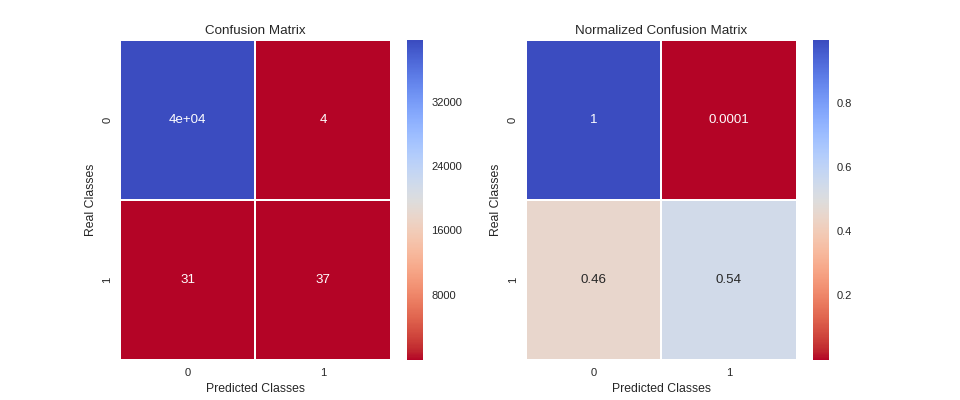

---Classification Report---
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     39805
          1       0.90      0.54      0.68        68

avg / total       1.00      1.00      1.00     39873



In [6]:
# Linear SVM on unsampled training data
lsvm = svm.LinearSVC(C=1.0, dual=False)
lsvm.fit(dataset['X_train'], dataset['y_train'])
y_pred = lsvm.predict(dataset['X_test'])
plot_confusion_matrix(dataset['y_test'], y_pred)

<IPython.core.display.Javascript object>


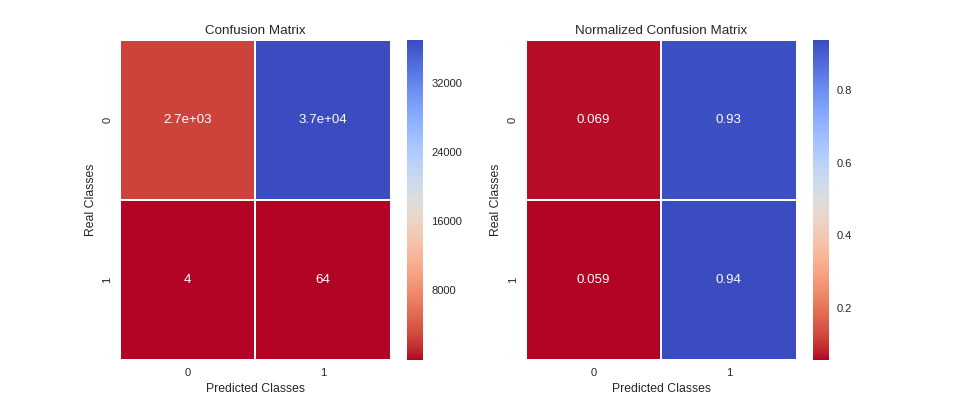

---Classification Report---
             precision    recall  f1-score   support

          0       1.00      0.07      0.13     39805
          1       0.00      0.94      0.00        68

avg / total       1.00      0.07      0.13     39873



In [15]:
# Linear SVM on ADASYN training data 
#svm_adasyn_unweighted_c0_01
lsvm = svm.LinearSVC(C=1, dual=False)
lsvm.fit(dataset['X_train_'], dataset['y_train_'])
y_pred = lsvm.predict(dataset['X_test_'])
plot_confusion_matrix(dataset['y_test_'], y_pred)

<IPython.core.display.Javascript object>


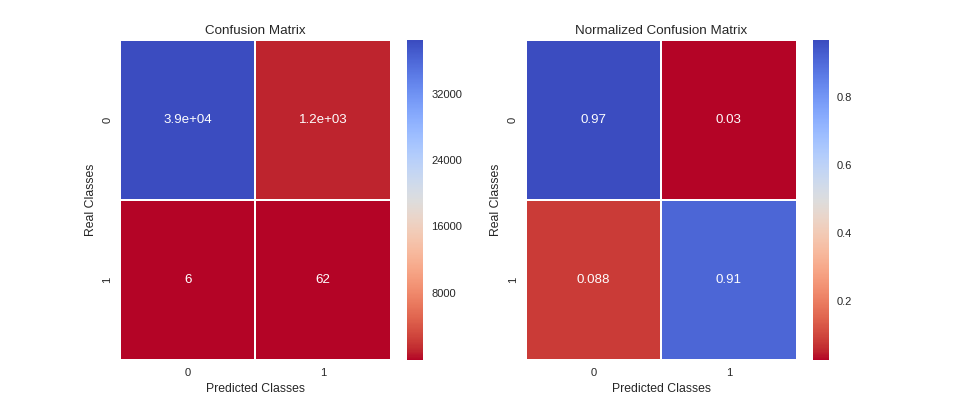

---Classification Report---
             precision    recall  f1-score   support

          0       1.00      0.97      0.98     39805
          1       0.05      0.91      0.09        68

avg / total       1.00      0.97      0.98     39873



In [25]:
# Linear SVM on WEIGHTED unsampled training data
lsvm = svm.LinearSVC(C=1.0, dual=False, class_weight={1:1000,0:1})
lsvm.fit(dataset['X_train'], dataset['y_train'])
y_pred = lsvm.predict(dataset['X_test'])
plot_confusion_matrix(dataset['y_test'], y_pred)

### SVM PRECISION RECALL CURVE

<IPython.core.display.Javascript object>


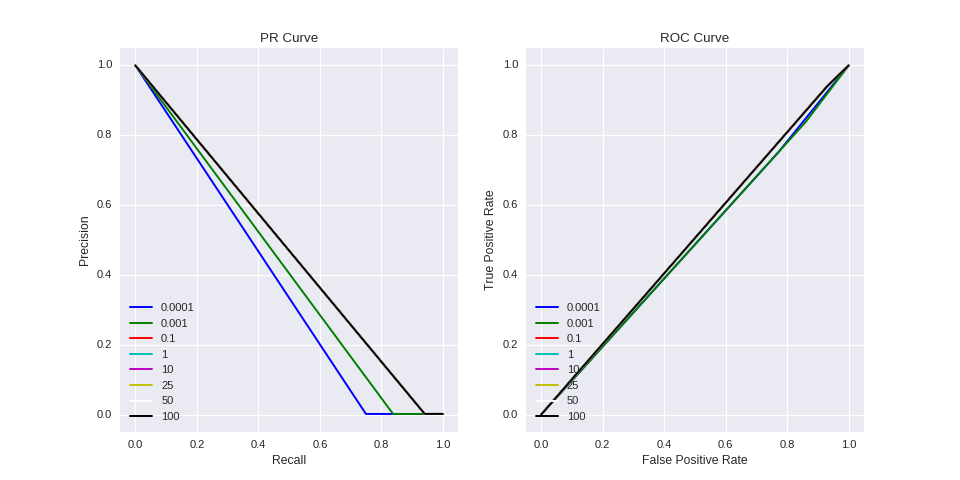

In [28]:
# finding the best C value
# svm_prec_recal_adasyn_different_c
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')

for c,k in zip([0.0001, 0.001, 0.1, 1, 10, 25, 50, 100],'bgrcmywk'):
    lsvm_ = svm.LinearSVC(C=c, dual=False, class_weight={1:1,0:1})
    lsvm_.fit(dataset['X_train_'], dataset['y_train_'])
    y_pred = lsvm_.predict(dataset['X_test_'])

    p,r,_ = precision_recall_curve(dataset['y_test_'], y_pred)
    tpr,fpr,_ = roc_curve(dataset['y_test_'], y_pred)
    
    ax1.plot(r,p,c=k,label=c)
    ax2.plot(tpr,fpr,c=k,label=c)

ax1.legend(loc='lower left')    
ax2.legend(loc='lower left')
plt.show()
# Conclusion: c > 0.1 is best

<IPython.core.display.Javascript object>


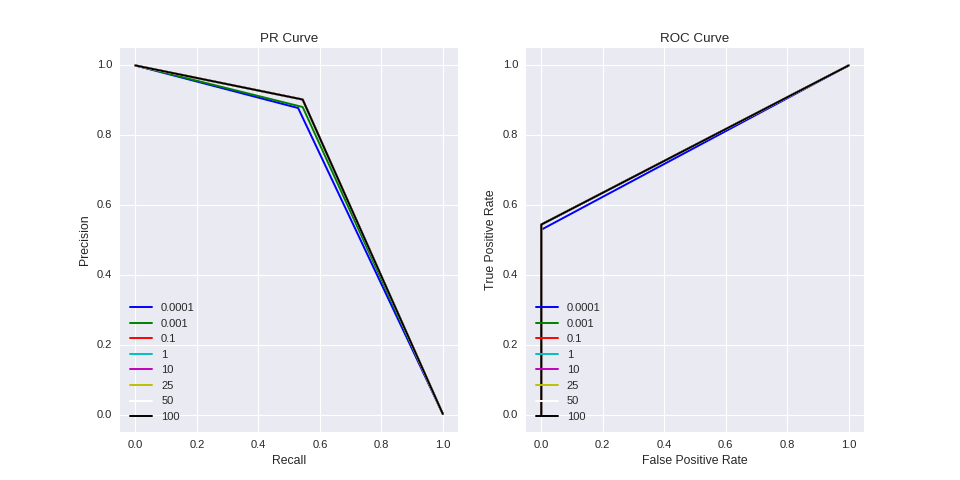

0.0001
0.001
0.1
1
10
25
50
100


In [4]:
# Same as above but with unsampled data
# svm_prec_recal_unsampled_unweighted_different_c
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')

for c,k in zip([0.0001, 0.001, 0.1, 1, 10, 25, 50, 100],'bgrcmywk'):
    print(c)
    lsvm_ = svm.LinearSVC(C=c, dual=False, class_weight={1:1,0:1})
    lsvm_.fit(dataset['X_train'], dataset['y_train'])
    y_pred = lsvm_.predict(dataset['X_test'])

    p,r,_ = precision_recall_curve(dataset['y_test'], y_pred)
    tpr,fpr,_ = roc_curve(dataset['y_test'], y_pred)
    
    ax1.plot(r,p,c=k,label=c)
    ax2.plot(tpr,fpr,c=k,label=c)

ax1.legend(loc='lower left')    
ax2.legend(loc='lower left')
plt.show()
# Conclusion: c > 0.1 is best

<IPython.core.display.Javascript object>


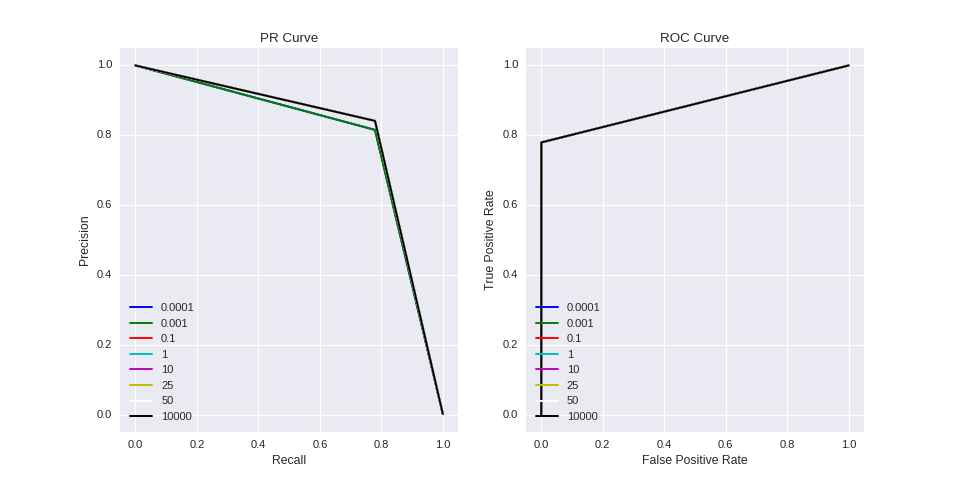

In [26]:
# Exploring C value with the weighted unsampled training data
# svm_prec_recal_weighted_unsampled_different_c
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')

for c,k in zip([0.0001, 0.001, 0.1, 1, 10, 25, 50, 10000],'bgrcmywk'):
    lsvm_ = svm.LinearSVC(C=c, dual=False, class_weight={1:10,0:1})
    lsvm_.fit(dataset['X_train'], dataset['y_train'])
    y_pred = lsvm_.predict(dataset['X_test'])

    p,r,_ = precision_recall_curve(dataset['y_test'], y_pred)
    tpr,fpr,_ = roc_curve(dataset['y_test'], y_pred)
    
    ax1.plot(r,p,c=k,label=c)
    ax2.plot(tpr,fpr,c=k,label=c)
    
ax1.legend(loc='lower left')    
ax2.legend(loc='lower left')
plt.show()
# CONCLUSION: c > 0.001 is best

<IPython.core.display.Javascript object>


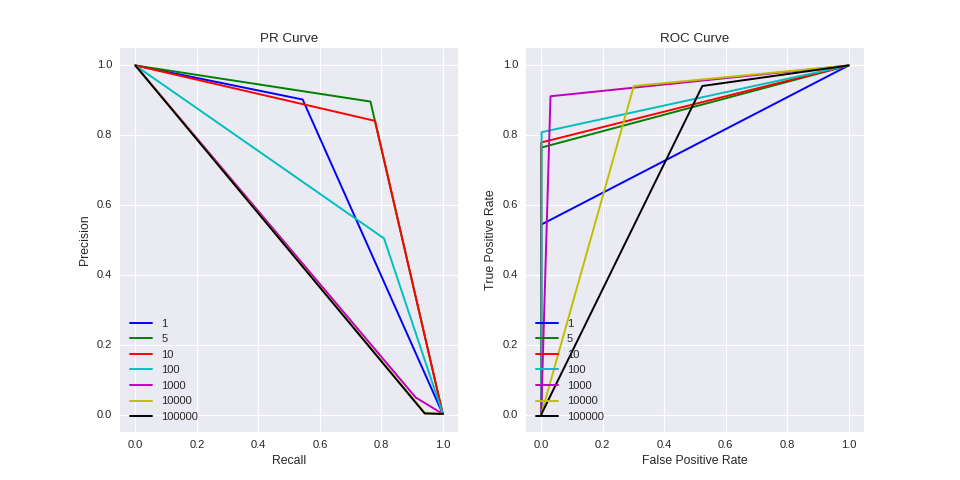

In [14]:
# Exploring "class_weight" with c=0.01 since according to above, does not matter. On unsampled data
# Note w=1 is the same as unweighted unsampled training data
#svm_prec_recal_unsampled_different_weights_c_1
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')

for w,k in zip([1, 5, 10, 100, 1000, 10000, 100000],'bgrcmyk'):
    lsvm_ = svm.LinearSVC(C=1, dual=False, class_weight={1:w,0:1})
    lsvm_.fit(dataset['X_train'], dataset['y_train'])
    y_pred = lsvm_.predict(dataset['X_test'])

    p,r,_ = precision_recall_curve(dataset['y_test'], y_pred, pos_label=1)
    tpr,fpr,_ = roc_curve(dataset['y_test'], y_pred)
    
    ax1.plot(r,p,c=k,label=w)
    ax2.plot(tpr,fpr,c=k,label=w)
    
ax1.legend(loc='lower left')    
ax2.legend(loc='lower left')
plt.show()
# Conclusion: weight of 5 for the minority class works best.
# Note: setting c=1 or c=100 produces the same plots.

<IPython.core.display.Javascript object>


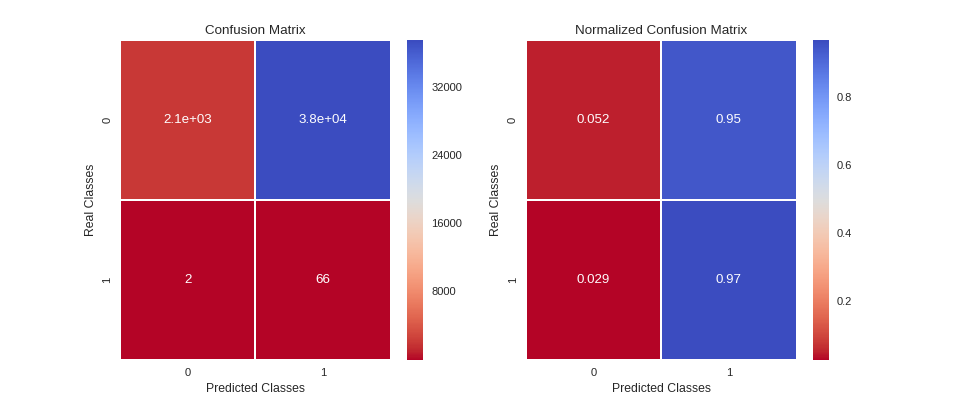

---Classification Report---
             precision    recall  f1-score   support

          0       1.00      0.05      0.10     39805
          1       0.00      0.97      0.00        68

avg / total       1.00      0.05      0.10     39873



<IPython.core.display.Javascript object>


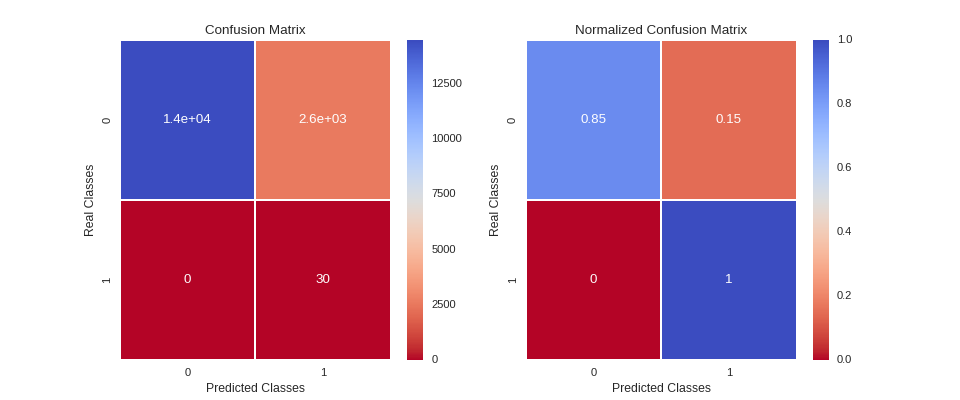

---Classification Report---
             precision    recall  f1-score   support

          0       1.00      0.85      0.92     17058
          1       0.01      1.00      0.02        30

avg / total       1.00      0.85      0.92     17088



In [18]:
# Linear SVM on WEIGHTED ADASYN training data with minority class weight of 10
# svm_adasyn_c_1_weight_10
lsvm = svm.LinearSVC(C=1, dual=False, class_weight={1:10,0:1})
lsvm.fit(dataset['X_train_'], dataset['y_train_'])
y_pred = lsvm.predict(dataset['X_test_'])
y_pred_validation = lsvm.predict(dataset['X_validation_'])
plot_confusion_matrix(dataset['y_test_'], y_pred)
plot_confusion_matrix(dataset['y_validation_'], y_pred_validation)

<IPython.core.display.Javascript object>


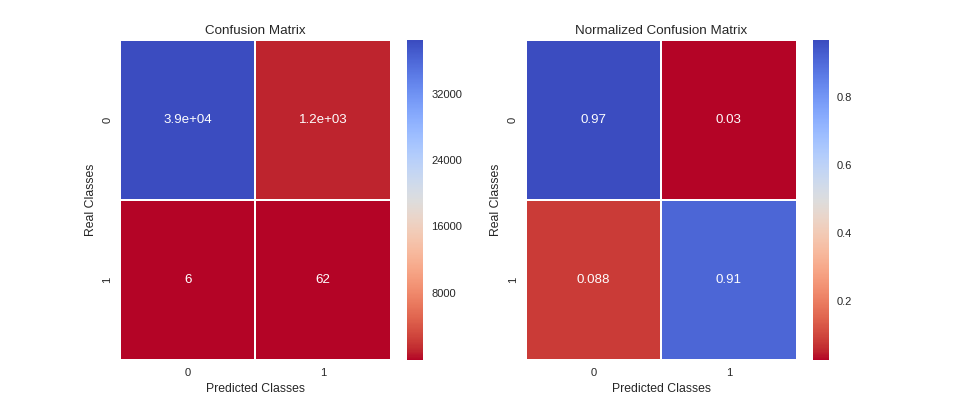

---Classification Report---
             precision    recall  f1-score   support

          0       1.00      0.97      0.98     39805
          1       0.05      0.91      0.09        68

avg / total       1.00      0.97      0.98     39873



<IPython.core.display.Javascript object>


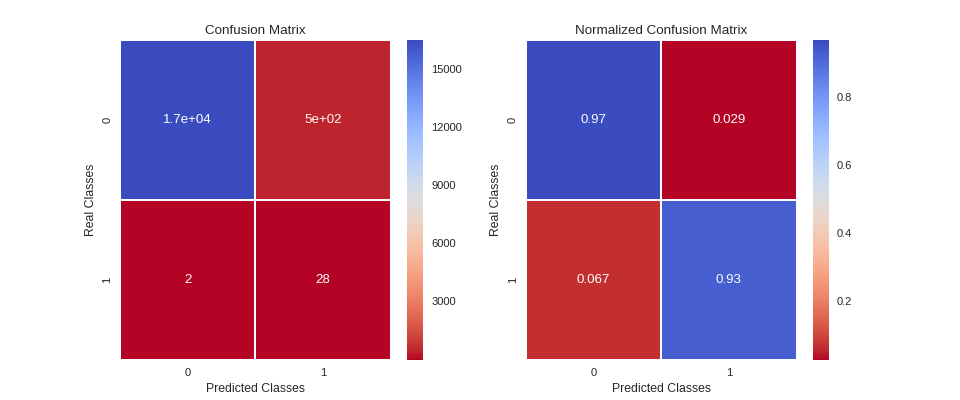

---Classification Report---
             precision    recall  f1-score   support

          0       1.00      0.97      0.98     17058
          1       0.05      0.93      0.10        30

avg / total       1.00      0.97      0.98     17088



In [7]:
# Linear SVM on WEIGHTED unsampled training data with minority class weight of 1000
lsvm = svm.LinearSVC(C=1, dual=False, class_weight={1:1000,0:1})
lsvm.fit(dataset['X_train'], dataset['y_train'])
y_pred = lsvm.predict(dataset['X_test'])
y_pred_validation = lsvm.predict(dataset['X_validation'])
plot_confusion_matrix(dataset['y_test'], y_pred)
plot_confusion_matrix(dataset['y_validation'], y_pred_validation)

fitting
predicting test
predicting validation


<IPython.core.display.Javascript object>


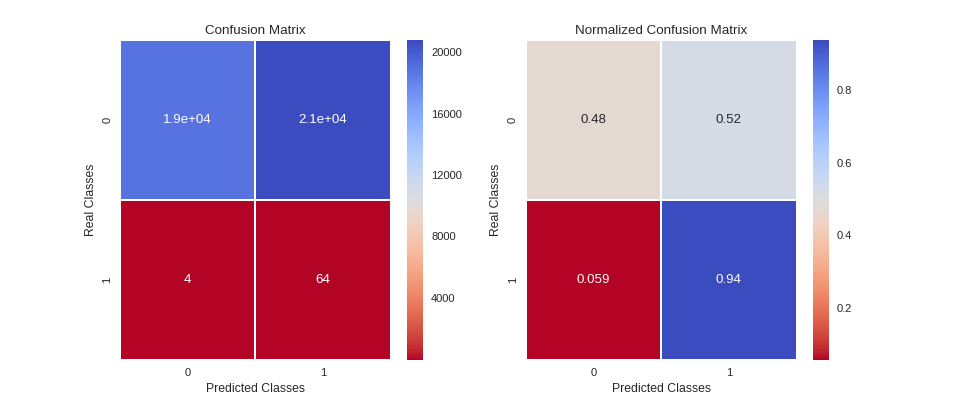

---Classification Report---
             precision    recall  f1-score   support

          0       1.00      0.48      0.64     39805
          1       0.00      0.94      0.01        68

avg / total       1.00      0.48      0.64     39873



<IPython.core.display.Javascript object>


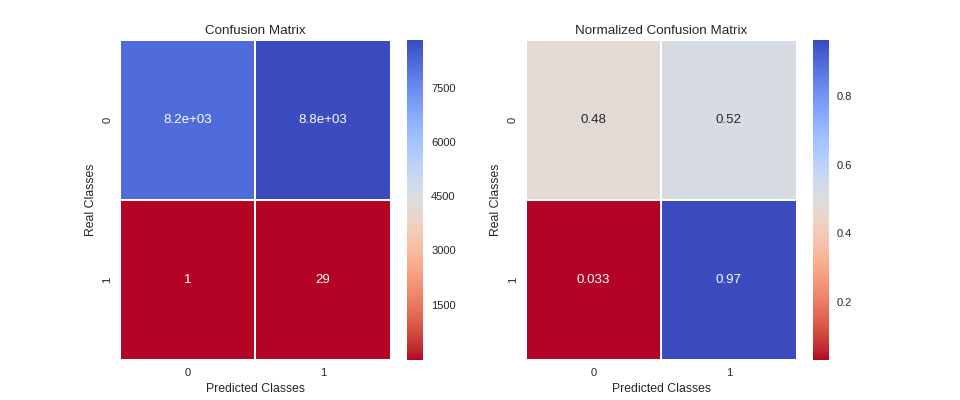

---Classification Report---
             precision    recall  f1-score   support

          0       1.00      0.48      0.65     17058
          1       0.00      0.97      0.01        30

avg / total       1.00      0.48      0.65     17088



In [10]:
# Linear SVM on WEIGHTED unsampled training data with minority class weight of 100000
lsvm = svm.LinearSVC(C=1, dual=False, class_weight={1:100000,0:1})
print('fitting')
lsvm.fit(dataset['X_train'], dataset['y_train'])
print('predicting test')
y_pred = lsvm.predict(dataset['X_test'])
print('predicting validation')
y_pred_validation = lsvm.predict(dataset['X_validation'])
plot_confusion_matrix(dataset['y_test'], y_pred)
plot_confusion_matrix(dataset['y_validation'], y_pred_validation)
# Conclusion: clearly too high of a minority class weight - compromising TP rate.

## b) RANDOM FOREST

<IPython.core.display.Javascript object>


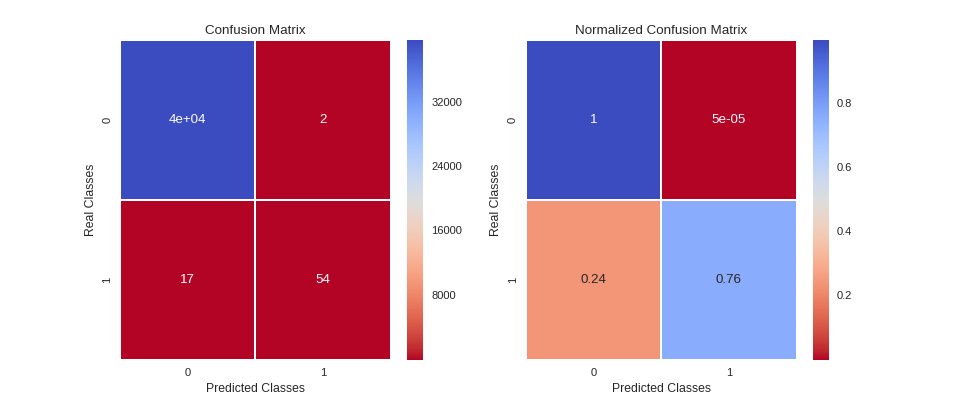

---Classification Report---
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     39802
          1       0.96      0.76      0.85        71

avg / total       1.00      1.00      1.00     39873



In [37]:
# Random Forest on unsampled training data
# rf_n_est_100_unsampled_unweighted
rf = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=4)
rf.fit(dataset['X_train'], dataset['y_train'])
y_pred = rf.predict(dataset['X_test'])
plot_confusion_matrix(dataset['y_test'], y_pred)

<IPython.core.display.Javascript object>


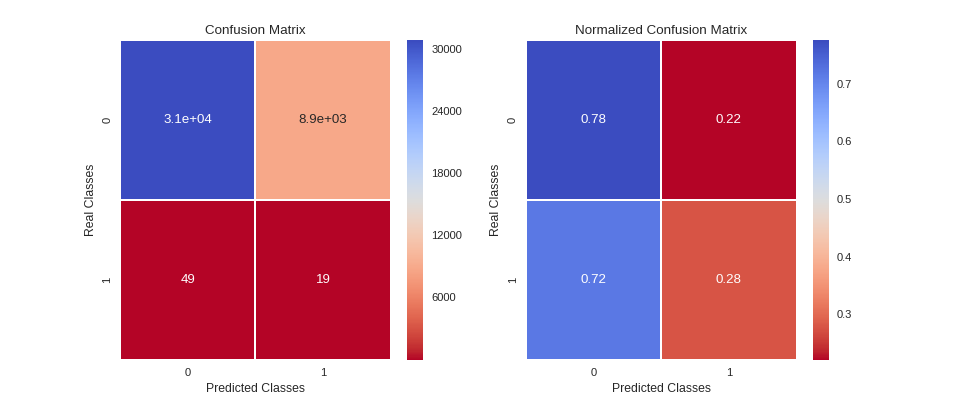

---Classification Report---
             precision    recall  f1-score   support

          0       1.00      0.78      0.87     39805
          1       0.00      0.28      0.00        68

avg / total       1.00      0.78      0.87     39873



In [17]:
# Random Forest on ADASYN training data
rf_adasyn = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=4)
rf_adasyn.fit(dataset['X_train_'], dataset['y_train_'])
y_pred = rf_adasyn.predict(dataset['X_test_'])
plot_confusion_matrix(dataset['y_test_'], y_pred)

<IPython.core.display.Javascript object>


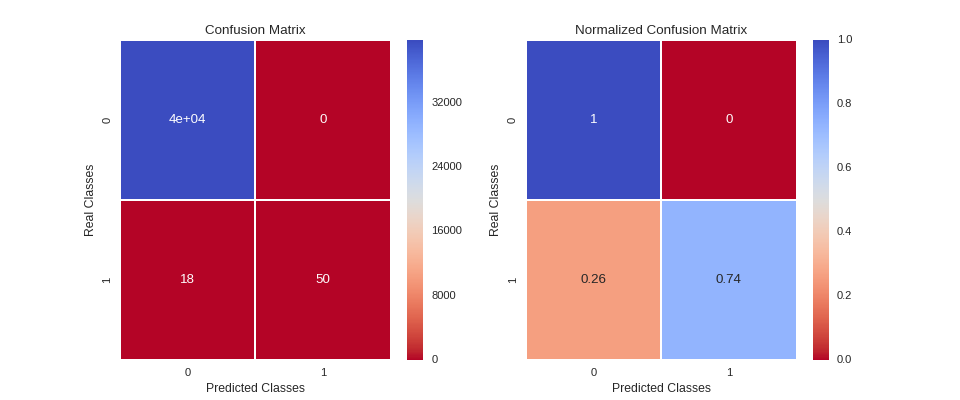

---Classification Report---
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     39805
          1       1.00      0.74      0.85        68

avg / total       1.00      1.00      1.00     39873



In [16]:
# Random Forest on WEIGHTED unsampled training data
rf = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=4, class_weight={1:10,0:1})
rf.fit(dataset['X_train'], dataset['y_train'])
y_pred = rf.predict(dataset['X_test'])
plot_confusion_matrix(dataset['y_test'], y_pred)

### PRECISION RECALL CURVES

<IPython.core.display.Javascript object>


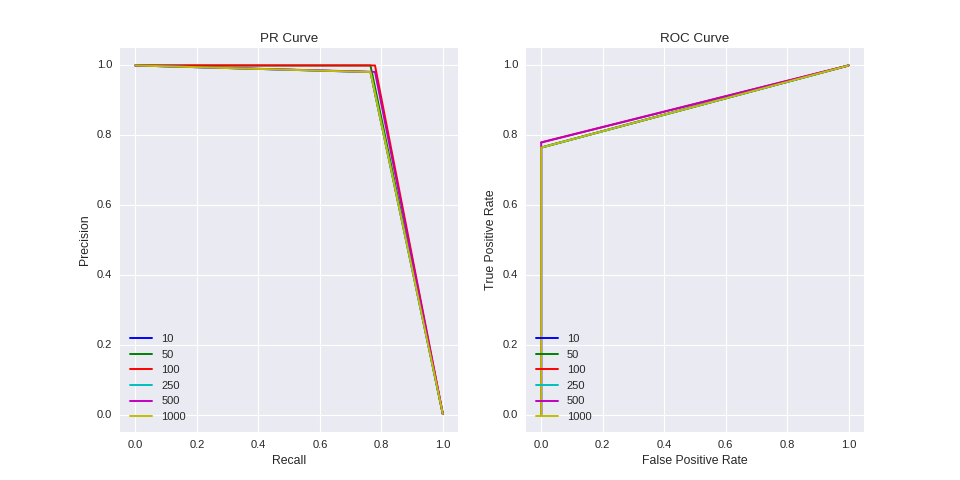

10
50
100
250
500
1000


In [15]:
# Unsampled training data 
# rf_prec_recall_n_est_unsampled_unweighted
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')

for n_est,k in zip([10, 50, 100, 250, 500, 1000],'bgrcmy'):
    print(n_est)
    rf = RandomForestClassifier(n_estimators=n_est, bootstrap=False, max_features=0.33, n_jobs=4)
    rf.fit(dataset['X_train'], dataset['y_train'])
    y_pred = rf.predict(dataset['X_test'])

    p,r,_ = precision_recall_curve(dataset['y_test'], y_pred)
    tpr,fpr,_ = roc_curve(dataset['y_test'], y_pred)
    
    ax1.plot(r,p,c=k,label=n_est)
    ax2.plot(tpr,fpr,c=k,label=n_est)

ax1.legend(loc='lower left')
ax2.legend(loc='lower left')
plt.show()
# Conclusion: n_estimators=100 is best

<IPython.core.display.Javascript object>


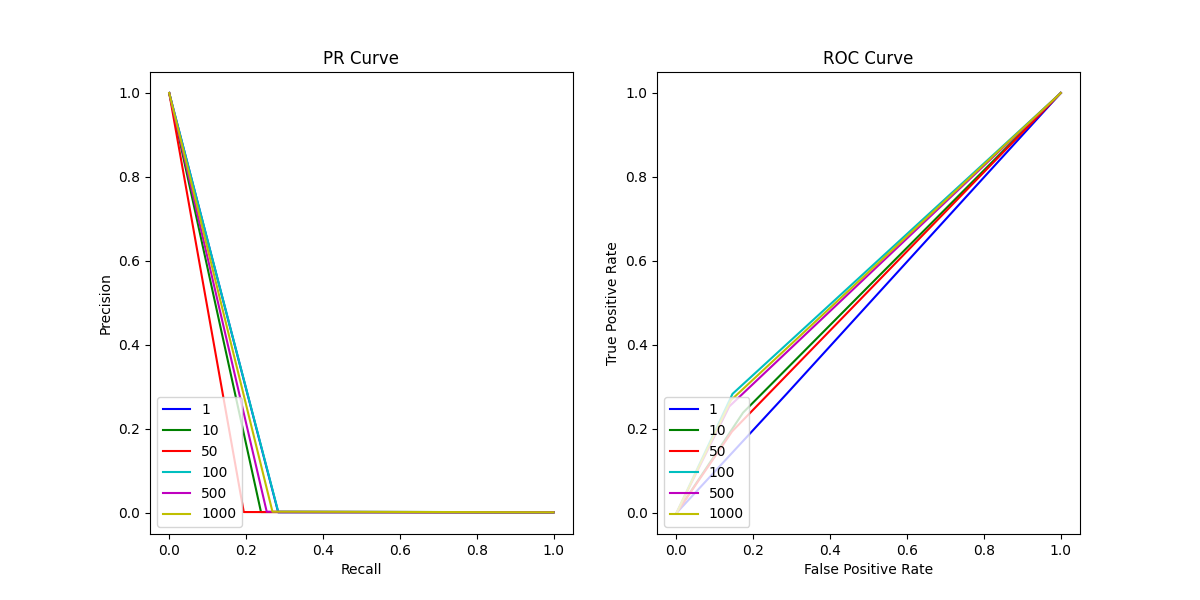

c:\users\tarandeep\appdata\local\programs\python\python37\lib\site-packages\sklearn\base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
c:\users\tarandeep\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\_forest.py:554: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,
c:\users\tarandeep\appdata\local\programs\python\python37\lib\site-packages\sklearn\base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
c:\users\tarandeep\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\_forest.py:554: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  Use

In [63]:
# finding the best C value 
#rf_prec_recall_n_est_adasyn_unweighted
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')

for n_est,k in zip([1, 10, 50, 100, 500, 1000],'bgrcmy'):
    rf_adasyn_ = RandomForestClassifier(n_estimators=n_est, oob_score=True, n_jobs=4)
    rf_adasyn_.fit(dataset['X_train_'], dataset['y_train_'])
    y_pred = rf_adasyn_.predict(dataset['X_test_'])

    p,r,_ = precision_recall_curve(dataset['y_test_'], y_pred)
    tpr,fpr,_ = roc_curve(dataset['y_test_'], y_pred)
    
    ax1.plot(r,p,c=k,label=n_est)
    ax2.plot(tpr,fpr,c=k,label=n_est)

ax1.legend(loc='lower left')    
ax2.legend(loc='lower left')
plt.show()

<IPython.core.display.Javascript object>


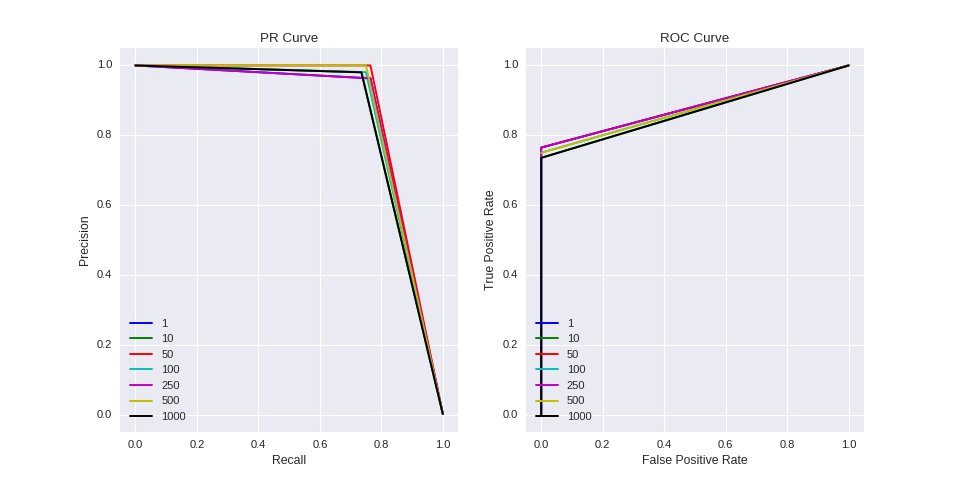

1
10
50
100
250
500
1000


In [17]:
# Unsampled training data, WEIGHTED 
# rf_prec_recall_n_est_unsampled_n_est_100_different_weights
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')

for w,k in zip([1, 10, 50, 100, 250, 500, 1000],'bgrcmyk'):
    print(w)
    rf = RandomForestClassifier(n_estimators=100, bootstrap=False, 
                                max_features=0.33, n_jobs=4, 
                                class_weight={1:w,0:1})
    rf.fit(dataset['X_train'], dataset['y_train'])
    y_pred = rf.predict(dataset['X_test'])

    p,r,_ = precision_recall_curve(dataset['y_test'], y_pred)
    tpr,fpr,_ = roc_curve(dataset['y_test'], y_pred)
    
    ax1.plot(r,p,c=k,label=w)
    ax2.plot(tpr,fpr,c=k,label=w)

ax1.legend(loc='lower left')
ax2.legend(loc='lower left')
plt.show()
# Conclusion: 50 works best

## c) MULTI-LAYER PERCEPTRON

Iteration 1, loss = 0.00580708
Iteration 2, loss = 0.00290610
Iteration 3, loss = 0.00264700
Iteration 4, loss = 0.00251043
Iteration 5, loss = 0.00240242
Iteration 6, loss = 0.00225784
Iteration 7, loss = 0.00220368
Iteration 8, loss = 0.00216249
Iteration 9, loss = 0.00204695
Iteration 10, loss = 0.00202412
Iteration 11, loss = 0.00196967
Iteration 12, loss = 0.00189707
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Setting learning rate to 0.020000
Iteration 13, loss = 0.00170818
Iteration 14, loss = 0.00166501
Iteration 15, loss = 0.00164642
Iteration 16, loss = 0.00163065
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Setting learning rate to 0.004000
Iteration 17, loss = 0.00158794
Iteration 18, loss = 0.00158033
Iteration 19, loss = 0.00157644
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Setting learning rate to 0.000800
Iteration 20, loss = 0.00156619
Iteration 21, loss = 0.0

<IPython.core.display.Javascript object>


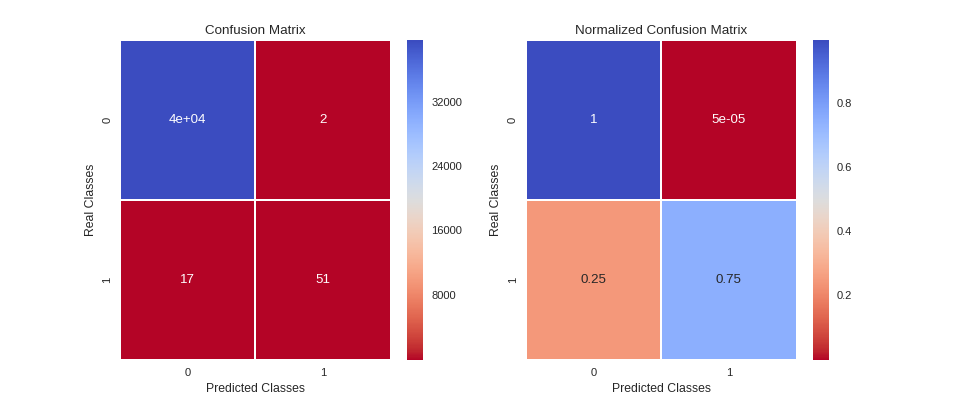

---Classification Report---
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     39805
          1       0.96      0.75      0.84        68

avg / total       1.00      1.00      1.00     39873



In [21]:
# MLP on unsampled training data
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=50,
                    solver='sgd', verbose=10, tol=1e-4, momentum=0.9,
                    learning_rate='adaptive', learning_rate_init=0.1)
mlp.fit(dataset['X_train'], dataset['y_train'])
y_pred = mlp.predict(dataset['X_test'])
plot_confusion_matrix(dataset['y_test'], y_pred)

Iteration 1, loss = 0.02955043
Iteration 2, loss = 0.00334991
Iteration 3, loss = 0.00279688
Iteration 4, loss = 0.00254439
Iteration 5, loss = 0.00235930
Iteration 6, loss = 0.00228663
Iteration 7, loss = 0.00214945
Iteration 8, loss = 0.00208838
Iteration 9, loss = 0.00199293
Iteration 10, loss = 0.00188649
Iteration 11, loss = 0.00188327
Iteration 12, loss = 0.00178455
Iteration 13, loss = 0.00169517
Iteration 14, loss = 0.00163943
Iteration 15, loss = 0.00161802
Iteration 16, loss = 0.00151716
Iteration 17, loss = 0.00150037
Iteration 18, loss = 0.00144918
Iteration 19, loss = 0.00143278
Iteration 20, loss = 0.00129247
Iteration 21, loss = 0.00130595
Iteration 22, loss = 0.00124852
Iteration 23, loss = 0.00125089
Iteration 24, loss = 0.00120472
Iteration 25, loss = 0.00121763
Iteration 26, loss = 0.00112522
Iteration 27, loss = 0.00107958
Iteration 28, loss = 0.00101999
Iteration 29, loss = 0.00102336
Iteration 30, loss = 0.00102903
Iteration 31, loss = 0.00095967
Iteration 32, los

<IPython.core.display.Javascript object>


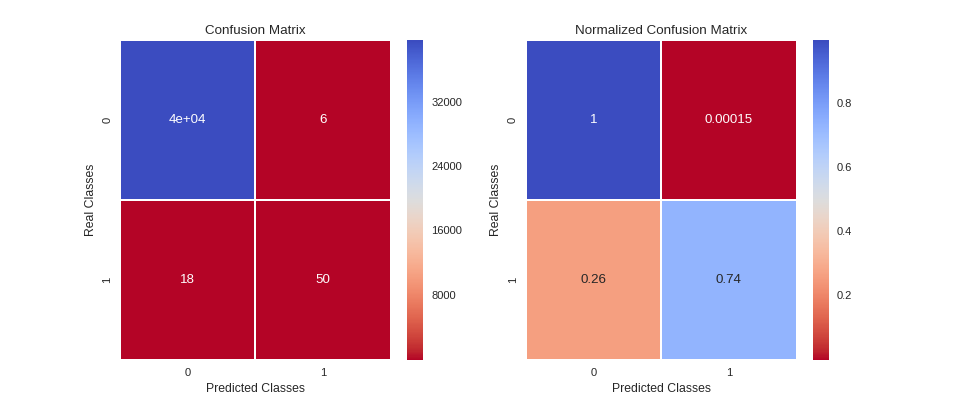

---Classification Report---
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     39805
          1       0.89      0.74      0.81        68

avg / total       1.00      1.00      1.00     39873



In [20]:
# MLP on unsampled training data
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=50,
                    solver='adam', verbose=10, tol=1e-6, momentum=0.9,
                    learning_rate='adaptive', learning_rate_init=0.001)
mlp.fit(dataset['X_train'], dataset['y_train'])
y_pred = mlp.predict(dataset['X_test'])
plot_confusion_matrix(dataset['y_test'], y_pred)

Iteration 1, loss = 0.08038942
Iteration 2, loss = 0.02789200
Iteration 3, loss = 0.01559238
Iteration 4, loss = 0.01003204
Iteration 5, loss = 0.00724619
Iteration 6, loss = 0.00571669
Iteration 7, loss = 0.00464596
Iteration 8, loss = 0.00391831
Iteration 9, loss = 0.00338153
Iteration 10, loss = 0.00295182
Iteration 11, loss = 0.00274460
Iteration 12, loss = 0.00238533
Iteration 13, loss = 0.00237201
Iteration 14, loss = 0.00205979
Iteration 15, loss = 0.00196707
Iteration 16, loss = 0.00186946
Iteration 17, loss = 0.00173432
Iteration 18, loss = 0.00157233
Iteration 19, loss = 0.00149745
Iteration 20, loss = 0.00151923
Iteration 21, loss = 0.00132686
Iteration 22, loss = 0.00132568
Iteration 23, loss = 0.00124286
Iteration 24, loss = 0.00118017
Iteration 25, loss = 0.00126700
Iteration 26, loss = 0.00108808
Iteration 27, loss = 0.00116161
Iteration 28, loss = 0.00105346
Iteration 29, loss = 0.00103113
Iteration 30, loss = 0.00105402
Iteration 31, loss = 0.00109298
Iteration 32, los

<IPython.core.display.Javascript object>


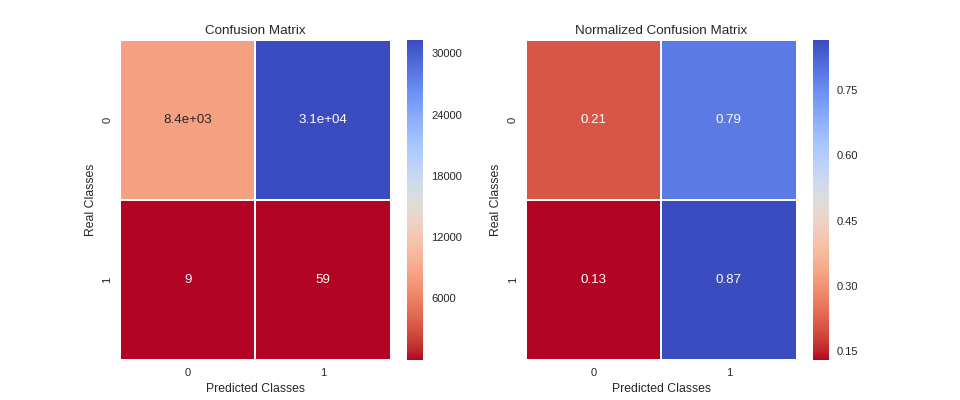

---Classification Report---
             precision    recall  f1-score   support

          0       1.00      0.21      0.35     39805
          1       0.00      0.87      0.00        68

avg / total       1.00      0.21      0.35     39873



In [18]:
# MLP on ADASYN training data, ADAM optimizer
mlp_adasyn = MLPClassifier(hidden_layer_sizes=(100,), max_iter=50,
                    solver='adam', verbose=10, tol=1e-6, momentum=0.9,
                    learning_rate='adaptive', learning_rate_init=0.001)
mlp_adasyn.fit(dataset['X_train_'], dataset['y_train_'])
y_pred = mlp_adasyn.predict(dataset['X_test_'])
plot_confusion_matrix(dataset['y_test_'], y_pred)

Iteration 1, loss = 0.03043777
Iteration 2, loss = 0.00828006
Iteration 3, loss = 0.00510962
Iteration 4, loss = 0.00434469
Iteration 5, loss = 0.00328003
Iteration 6, loss = 0.00283019
Iteration 7, loss = 0.00254610
Iteration 8, loss = 0.00222054
Iteration 9, loss = 0.00202894
Iteration 10, loss = 0.00186523
Iteration 11, loss = 0.00225820
Iteration 12, loss = 0.00180707
Iteration 13, loss = 0.00148821
Iteration 14, loss = 0.00140052
Iteration 15, loss = 0.00144710
Iteration 16, loss = 0.00129740
Iteration 17, loss = 0.00125205
Iteration 18, loss = 0.00138347
Iteration 19, loss = 0.00139486
Iteration 20, loss = 0.00102857
Iteration 21, loss = 0.00096264
Iteration 22, loss = 0.00091850
Iteration 23, loss = 0.00128970
Iteration 24, loss = 0.00086284
Iteration 25, loss = 0.00081434
Iteration 26, loss = 0.00085414
Iteration 27, loss = 0.00079440
Iteration 28, loss = 0.00070720
Iteration 29, loss = 0.00065653
Iteration 30, loss = 0.00064887
Iteration 31, loss = 0.00058929
Iteration 32, los

c:\users\tarandeep\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


<IPython.core.display.Javascript object>


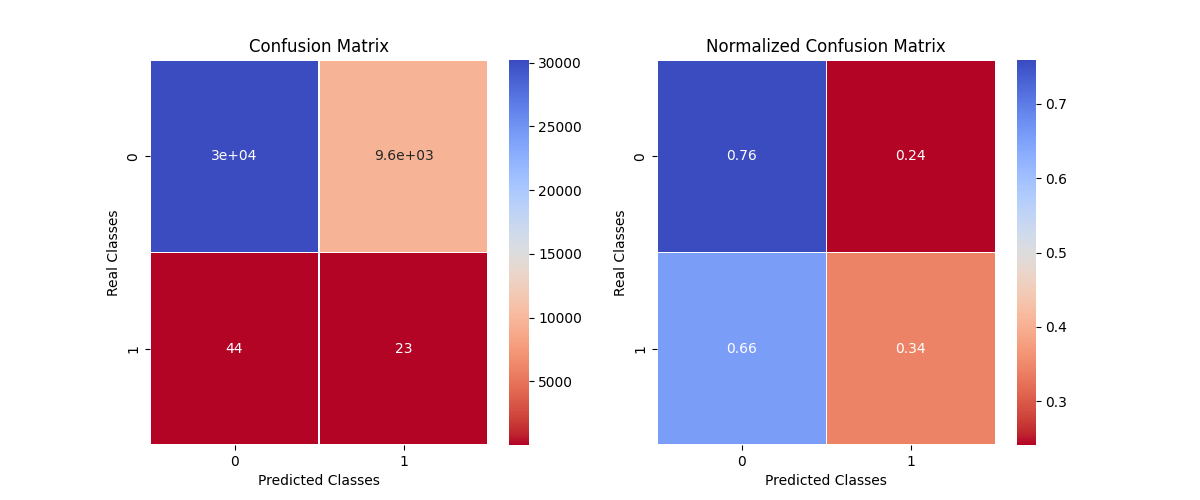

---Classification Report---
              precision    recall  f1-score   support

           0       1.00      0.76      0.86     39806
           1       0.00      0.34      0.00        67

    accuracy                           0.76     39873
   macro avg       0.50      0.55      0.43     39873
weighted avg       1.00      0.76      0.86     39873



In [64]:
# MLP on ADASYN training data, SGD
mlp_adasyn = MLPClassifier(hidden_layer_sizes=(100,), max_iter=50,
                    solver='sgd', verbose=10, tol=1e-6, momentum=0.9,
                    learning_rate='adaptive', learning_rate_init=0.1)
mlp_adasyn.fit(dataset['X_train_'], dataset['y_train_'])
y_pred = mlp_adasyn.predict(dataset['X_test_'])
plot_confusion_matrix(dataset['y_test_'], y_pred)

### PRECISION RECALL CURVES

<IPython.core.display.Javascript object>


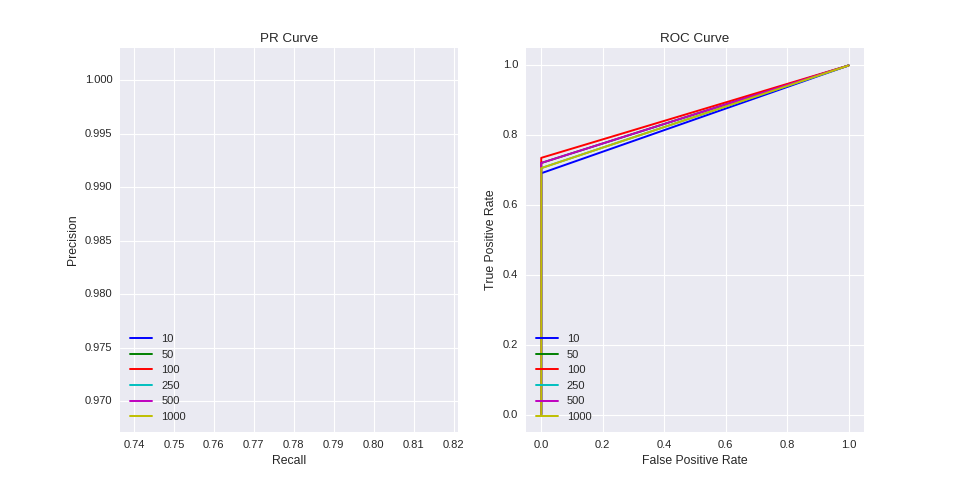

10
Iteration 1, loss = 0.02328592
Iteration 2, loss = 0.00445930
Iteration 3, loss = 0.00384488
Iteration 4, loss = 0.00363661
Iteration 5, loss = 0.00351536
Iteration 6, loss = 0.00341650
Iteration 7, loss = 0.00333910
Iteration 8, loss = 0.00328281
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Setting learning rate to 0.002000
Iteration 9, loss = 0.00322015
Iteration 10, loss = 0.00320954
Iteration 11, loss = 0.00319982
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Setting learning rate to 0.000400
Iteration 12, loss = 0.00318803
Iteration 13, loss = 0.00318599
Iteration 14, loss = 0.00318417
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Setting learning rate to 0.000080
Iteration 15, loss = 0.00318163
Iteration 16, loss = 0.00318127
Iteration 17, loss = 0.00318087
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Setting learning rate to 0.000016
It

In [7]:
# Unsampled training data
# mlp_prec_recall_n_layer_unsampled_unweighted_sgd_0_01
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')

for n_l,k in zip([10, 50, 100, 250, 500, 1000],'bgrcmy'):
    print(n_l)
    mlp = MLPClassifier(hidden_layer_sizes=(n_l,), max_iter=50,
                    solver='sgd', verbose=10, tol=1e-4, momentum=0.9,
                    learning_rate='adaptive', learning_rate_init=0.01)
    mlp.fit(dataset['X_train'], dataset['y_train'])
    y_pred = mlp.predict(dataset['X_test'])

    p,r,_ = precision_recall_curve(dataset['y_test'], y_pred)
    tpr,fpr,_ = roc_curve(dataset['y_test'], y_pred)
    
    ax1.plot(r,p,c=k,label=n_l)
    ax2.plot(tpr,fpr,c=k,label=n_l)

ax1.legend(loc='lower left')
ax2.legend(loc='lower left')
plt.show()

<IPython.core.display.Javascript object>


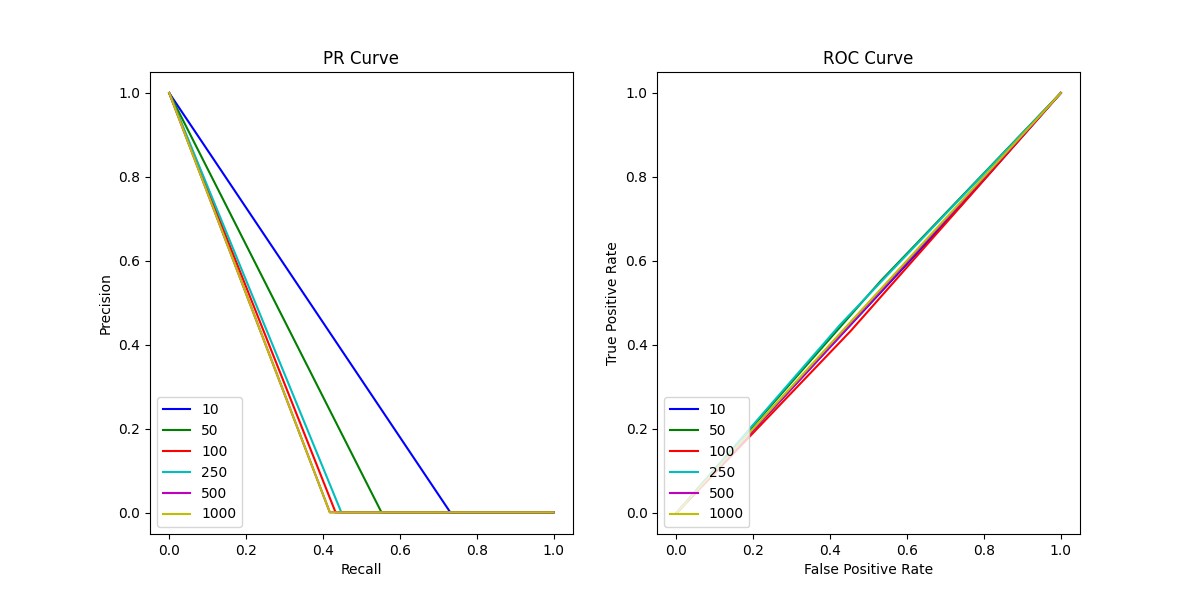

10
Iteration 1, loss = 0.10620620
Iteration 2, loss = 0.05612826
Iteration 3, loss = 0.04523651
Iteration 4, loss = 0.03974409
Iteration 5, loss = 0.03625733
Iteration 6, loss = 0.03367178
Iteration 7, loss = 0.03171780
Iteration 8, loss = 0.03008136
Iteration 9, loss = 0.02866928
Iteration 10, loss = 0.02747894
Iteration 11, loss = 0.02657782
Iteration 12, loss = 0.02561384
Iteration 13, loss = 0.02477252
Iteration 14, loss = 0.02404729
Iteration 15, loss = 0.02346416
Iteration 16, loss = 0.02284966
Iteration 17, loss = 0.02241321
Iteration 18, loss = 0.02196372
Iteration 19, loss = 0.02154278
Iteration 20, loss = 0.02114405
Iteration 21, loss = 0.02076471
Iteration 22, loss = 0.02041757
Iteration 23, loss = 0.02007598
Iteration 24, loss = 0.01972578
Iteration 25, loss = 0.01944200
Iteration 26, loss = 0.01918446
Iteration 27, loss = 0.01890317
Iteration 28, loss = 0.01864769
Iteration 29, loss = 0.01845404
Iteration 30, loss = 0.01822823
Iteration 31, loss = 0.01797923
Iteration 32, 

c:\users\tarandeep\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 1, loss = 0.08508072
Iteration 2, loss = 0.04549688
Iteration 3, loss = 0.03427458
Iteration 4, loss = 0.02758580
Iteration 5, loss = 0.02309082
Iteration 6, loss = 0.01979683
Iteration 7, loss = 0.01720647
Iteration 8, loss = 0.01513648
Iteration 9, loss = 0.01348241
Iteration 10, loss = 0.01217254
Iteration 11, loss = 0.01111812
Iteration 12, loss = 0.01023294
Iteration 13, loss = 0.00946121
Iteration 14, loss = 0.00881623
Iteration 15, loss = 0.00824304
Iteration 16, loss = 0.00774692
Iteration 17, loss = 0.00731130
Iteration 18, loss = 0.00693651
Iteration 19, loss = 0.00660687
Iteration 20, loss = 0.00629766
Iteration 21, loss = 0.00601689
Iteration 22, loss = 0.00578724
Iteration 23, loss = 0.00554439
Iteration 24, loss = 0.00535182
Iteration 25, loss = 0.00515528
Iteration 26, loss = 0.00497941
Iteration 27, loss = 0.00481492
Iteration 28, loss = 0.00465129
Iteration 29, loss = 0.00452395
Iteration 30, loss = 0.00439001
Iteration 31, loss = 0.00428004
Iteration 32, los

c:\users\tarandeep\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 1, loss = 0.08249436
Iteration 2, loss = 0.04199541
Iteration 3, loss = 0.02978223
Iteration 4, loss = 0.02308741
Iteration 5, loss = 0.01879519
Iteration 6, loss = 0.01587168
Iteration 7, loss = 0.01374190
Iteration 8, loss = 0.01210768
Iteration 9, loss = 0.01081951
Iteration 10, loss = 0.00970868
Iteration 11, loss = 0.00879819
Iteration 12, loss = 0.00803946
Iteration 13, loss = 0.00742772
Iteration 14, loss = 0.00690341
Iteration 15, loss = 0.00648887
Iteration 16, loss = 0.00612128
Iteration 17, loss = 0.00580301
Iteration 18, loss = 0.00551800
Iteration 19, loss = 0.00527000
Iteration 20, loss = 0.00504828
Iteration 21, loss = 0.00484568
Iteration 22, loss = 0.00467666
Iteration 23, loss = 0.00450862
Iteration 24, loss = 0.00436352
Iteration 25, loss = 0.00421473
Iteration 26, loss = 0.00407886
Iteration 27, loss = 0.00396079
Iteration 28, loss = 0.00384809
Iteration 29, loss = 0.00373187
Iteration 30, loss = 0.00362895
Iteration 31, loss = 0.00353100
Iteration 32, los

c:\users\tarandeep\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 1, loss = 0.08179940
Iteration 2, loss = 0.03994976
Iteration 3, loss = 0.02783578
Iteration 4, loss = 0.02138398
Iteration 5, loss = 0.01726005
Iteration 6, loss = 0.01451482
Iteration 7, loss = 0.01246627
Iteration 8, loss = 0.01092423
Iteration 9, loss = 0.00968054
Iteration 10, loss = 0.00869075
Iteration 11, loss = 0.00792926
Iteration 12, loss = 0.00730196
Iteration 13, loss = 0.00677056
Iteration 14, loss = 0.00633580
Iteration 15, loss = 0.00596392
Iteration 16, loss = 0.00561031
Iteration 17, loss = 0.00533916
Iteration 18, loss = 0.00506778
Iteration 19, loss = 0.00484014
Iteration 20, loss = 0.00462983
Iteration 21, loss = 0.00444012
Iteration 22, loss = 0.00425391
Iteration 23, loss = 0.00410466
Iteration 24, loss = 0.00394505
Iteration 25, loss = 0.00380847
Iteration 26, loss = 0.00366887
Iteration 27, loss = 0.00355103
Iteration 28, loss = 0.00343847
Iteration 29, loss = 0.00334652
Iteration 30, loss = 0.00324055
Iteration 31, loss = 0.00314059
Iteration 32, los

c:\users\tarandeep\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 1, loss = 0.08157269
Iteration 2, loss = 0.03969734
Iteration 3, loss = 0.02782392
Iteration 4, loss = 0.02144759
Iteration 5, loss = 0.01739150
Iteration 6, loss = 0.01458316
Iteration 7, loss = 0.01251155
Iteration 8, loss = 0.01089465
Iteration 9, loss = 0.00961464
Iteration 10, loss = 0.00860021
Iteration 11, loss = 0.00777443
Iteration 12, loss = 0.00713113
Iteration 13, loss = 0.00660144
Iteration 14, loss = 0.00615934
Iteration 15, loss = 0.00575524
Iteration 16, loss = 0.00543654
Iteration 17, loss = 0.00515218
Iteration 18, loss = 0.00489146
Iteration 19, loss = 0.00464574
Iteration 20, loss = 0.00444957
Iteration 21, loss = 0.00424882
Iteration 22, loss = 0.00407353
Iteration 23, loss = 0.00391118
Iteration 24, loss = 0.00376621
Iteration 25, loss = 0.00362966
Iteration 26, loss = 0.00350787
Iteration 27, loss = 0.00338050
Iteration 28, loss = 0.00326910
Iteration 29, loss = 0.00316545
Iteration 30, loss = 0.00306624
Iteration 31, loss = 0.00297962
Iteration 32, los

c:\users\tarandeep\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


1000
Iteration 1, loss = 0.08187897
Iteration 2, loss = 0.03966383
Iteration 3, loss = 0.02763341
Iteration 4, loss = 0.02120534
Iteration 5, loss = 0.01716067
Iteration 6, loss = 0.01437779
Iteration 7, loss = 0.01230046
Iteration 8, loss = 0.01070536
Iteration 9, loss = 0.00941476
Iteration 10, loss = 0.00840678
Iteration 11, loss = 0.00758614
Iteration 12, loss = 0.00693074
Iteration 13, loss = 0.00640055
Iteration 14, loss = 0.00595006
Iteration 15, loss = 0.00556205
Iteration 16, loss = 0.00523438
Iteration 17, loss = 0.00494569
Iteration 18, loss = 0.00468655
Iteration 19, loss = 0.00445504
Iteration 20, loss = 0.00424303
Iteration 21, loss = 0.00405061
Iteration 22, loss = 0.00388743
Iteration 23, loss = 0.00372948
Iteration 24, loss = 0.00358991
Iteration 25, loss = 0.00345301
Iteration 26, loss = 0.00332475
Iteration 27, loss = 0.00321437
Iteration 28, loss = 0.00310941
Iteration 29, loss = 0.00301009
Iteration 30, loss = 0.00291985
Iteration 31, loss = 0.00283088
Iteration 32

c:\users\tarandeep\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [65]:
# Unsampled training data
# mlp_prec_recall_n_layer_adasyn_unweighted_sgd_0_01
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')

for n_l,k in zip([10, 50, 100, 250, 500, 1000],'bgrcmy'):
    print(n_l)
    mlp = MLPClassifier(hidden_layer_sizes=(n_l,), max_iter=50,
                    solver='sgd', verbose=10, tol=1e-4, momentum=0.9,
                    learning_rate='adaptive', learning_rate_init=0.01)
    mlp.fit(dataset['X_train_'], dataset['y_train_'])
    y_pred = mlp.predict(dataset['X_test_'])

    p,r,_ = precision_recall_curve(dataset['y_test_'], y_pred)
    tpr,fpr,_ = roc_curve(dataset['y_test_'], y_pred)
    
    ax1.plot(r,p,c=k,label=n_l)
    ax2.plot(tpr,fpr,c=k,label=n_l)

ax1.legend(loc='lower left')
ax2.legend(loc='lower left')
plt.show()